# Introduction

- paper : https://arxiv.org/pdf/1512.03385

- ResNet, short for Residual Network, was introduced in the paper "Deep Residual Learning for Image Recognition" by Kaiming He et al., and won the ImageNet competition in 2015.
- ResNet (Residual Network) won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2015

* Key Concept: Residual Learning
 - The core idea behind ResNet is the use of skip connections (also called residual connections). In traditional deep networks, as layers are added, the network faces difficulty in learning due to vanishing gradients. ResNet overcomes this by allowing the network to skip layers, thereby helping in the flow of gradients during backpropagation.

* A residual block in ResNet consists of:

 1. Input
 2. A series of convolutional layers
 3. A skip connection that adds the input directly to the output of the convolutional layers.
 - The operation can be written as: 𝑦 = 𝐹 (𝑥, {𝑊𝑖}) + 𝑥

   - x is the input,
   - 𝐹
(
𝑥
,
{
𝑊
𝑖
}
)
F(x,{W
i
​
 }) represents the transformation learned by the convolutional layers (with weights
𝑊
𝑖
W
i
​
 ),
𝑦
   - y is the output.

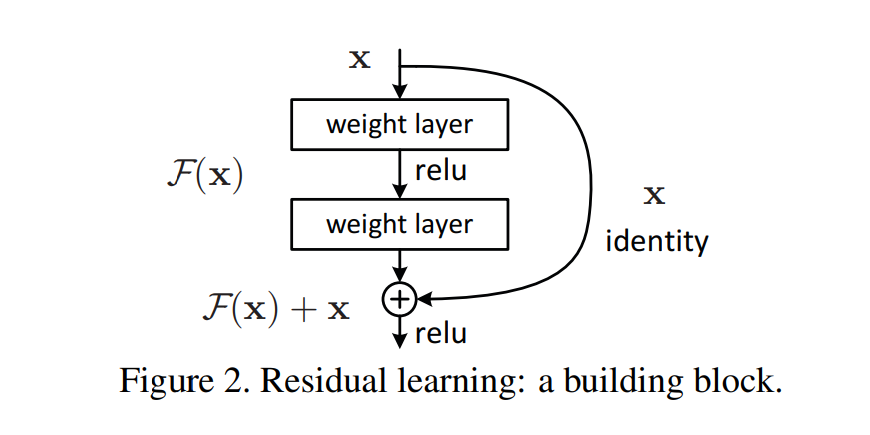

* **Advantages**

 - **Deeper Architectures:** ResNet allows for the creation of much deeper networks (with hundreds or even thousands of layers) without suffering from the vanishing gradient problem. This was previously a major bottleneck in training deep networks.

 - **Bypass Path for Gradients:** The skip connection creates a shortcut for gradients to bypass multiple layers during backpropagation. This prevents them from becoming too small (vanishing) as they move through the deep network.

 - **Identity Mapping:** If the residual mapping
F(x) is close to zero, the network can simply learn an identity mapping (
y=x), which ensures that the gradients can propagate unaltered to earlier layers, helping maintain their strength.

In [1]:
pip install torchview

In [3]:
import torch.nn as nn
import torch
from torchview import draw_graph


In [4]:
class ResidualBlock(nn.Module):

    def __init__(self,in_channels,out_channels,stride=1):
        super(ResidualBlock,self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=stride,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()

        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_channels)
        )


        self.downsample = None

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels=out_channels,kernel_size=1,stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU()

        self.out_channels = out_channels

    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out




In [15]:
class ResNet18(nn.Module):
    def __init__(self,block,layers,num_classes=1000):
        super(ResNet18,self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer0 = self._make_layer(block,64,layers[0],stride=1)
        self.layer1 = self._make_layer(block,128,layers[1],stride=2)
        self.layer2 = self._make_layer(block,256,layers[2],stride=2)
        self.layer3 = self._make_layer(block,512,layers[3],stride=2)

        self.avgpool = nn.AvgPool2d(7,stride=1)
        self.fc = nn.Linear(512,num_classes)

    def _make_layer(self,block,out_channels,num_blocks,stride=1):
        layers = []
        layers.append(block(self.in_channels,out_channels,stride))
        self.in_channels = out_channels

        for i in range(1,num_blocks):
            layers.append(block(self.in_channels,out_channels))

        return nn.Sequential(*layers)


    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x =self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x




In [16]:
model = ResNet18(ResidualBlock,[2,2,2,2])

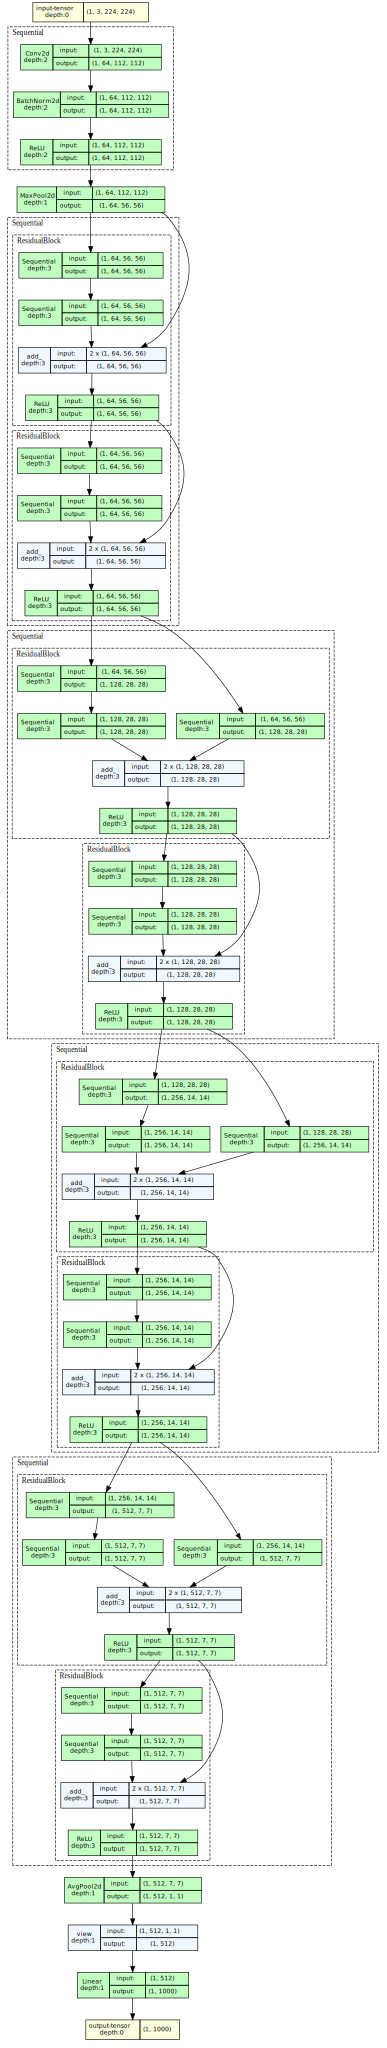

In [17]:
draw_graph(model,input_size=(1,3,224,224),expand_nested=True).visual_graph